In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
#IMPORTS
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import datetime

In [4]:
loc = 'nw2'
turbine = 'c02'
mode = 'SS2'

In [43]:
# Initialize the folders
package_folder = os.path.dirname(os.path.dirname(os.path.dirname(os.getcwd())))
data_folder = os.path.join(package_folder, 'data')
models_folder = os.path.join(package_folder, 'models')
data_folder

'c:\\Users\\Max\\Documents\\OWI_LAB\\Code\\DCE_EOVnorm\\dce_eov_normalisation\\data'

In [38]:
selected_columns = ['mean_NW2_C02_rpm', 'mean_NW2_C02_pitch', 'mean_NW2_C02_power',
       'mean_NW2_C02_windspeed', 'sin_mean_NW2_C02_yaw',
       'cos_mean_NW2_C02_yaw', 'sin_mean_NW2_C02_winddirection',
       'cos_mean_NW2_C02_winddirection',
       'mvbc_WandelaarBuoy_Wave_height',
       'mvbc_WandelaarBuoy_Average_wave_period',
       'mvbc_WandelaarMeasuringpile_Tide_TAW',
       'mvbc_WandelaarMeasuringpile_Air_pressure',
       'mvbc_WandelaarMeasuringpile_Air_temperature']

In [134]:
# GET THE DATA
# load the training data full
from src.data.make_dataset import create_input_target_dataset
inputs_training_full, ss2_training_full = create_input_target_dataset(data_folder, loc, turbine, mode)

#load the predictions of the training data
predictions_df_training = pd.read_parquet(os.path.join(data_folder, 'processed', loc, turbine+'_'+mode+'_mode_prediction_large_training.parquet'))
smart_tracked_modes_training = pd.read_parquet(os.path.join(data_folder, 'processed', loc, turbine+'_'+mode+'_smart_tracked_modes_large_training.parquet'))
case_IDS = pd.read_csv(os.path.join(data_folder, 'interim', loc,'labeled', loc+turbine+'_case.csv'))
case_IDS.set_index('timestamp', inplace=True)
case_IDS.index = pd.to_datetime(case_IDS.index) 

# load the training data selected
selected_data_large = pd.read_csv(os.path.join(data_folder, 'processed','nw2', turbine+'_ss2_selected_data_large.csv'))
# Remove the selecyted data with duplicated timestamps and keep the one with the biggest size
selected_data_sorted = selected_data_large.sort_values(by='size', ascending=False)
selected_data_unique = selected_data_sorted.drop_duplicates(subset='timestamp', keep='first')
selected_data_unique = selected_data_unique.sort_values(by='timestamp')

# load the test data
test_data_path = '_'.join([loc, turbine, mode, 'test_data.parquet'])
test_turbine_data = pd.read_parquet(os.path.join(data_folder, 'raw', loc, test_data_path))

dropped mvbc columns:  {'mvbc_WandelaarBuoy_Sea_water_temperature', 'mvbc_WandelaarMeasuringpile_Relative_humidity'}


In [135]:
ss2_df = pd.DataFrame(ss2_training_full, index=inputs_training_full.index, columns=['frequency'])
ss2_df['caseID'] = case_IDS.loc[ss2_df.index]['caseID']

In [169]:
ss2_df['caseID'].unique()

array(['parked: Turbine parked, pitched at >87, rotating at less than 0.4RPM',
       'Curtailed (All): Catchall for data points that fall out of the normal behaviour',
       'rpm<Max: Turbine speeding up to rated RPM',
       'cutin (pitch > 20): Turbine speeding up to operational speeds',
       'rpm6.6: Turbine rotating at 6.6 RPM',
       'rpm<6.6: Turbine rotating up to 6.6RPM',
       'cutin: Turbine speeding up to operational speeds',
       'pitch:78: Turbine pitched at 78deg.', nan,
       'Rated RPM: Turbine rotating at 10.4rpm or 10.445rpm',
       'Rated power: Turbine at rated power (9525kW)',
       'High wind: Turbine reducing output power at extreme wind speeds',
       'idling: Generic idling (no constraint on pitch)'], dtype=object)

In [201]:
turbine_cases = np.array([
    'parked: Turbine parked, pitched at >87, rotating at less than 0.4RPM',
    'pitch:78: Turbine pitched at 78deg.',
    'idling: Generic idling (no constraint on pitch)',
    'cutin: Turbine speeding up to operational speeds',
    'cutin (pitch > 20): Turbine speeding up to operational speeds',
    'rpm<6.6: Turbine rotating up to 6.6RPM',
    'rpm6.6: Turbine rotating at 6.6 RPM',
    'rpm<Max: Turbine speeding up to rated RPM',
    'Rated RPM: Turbine rotating at 10.4rpm or 10.445rpm',
    'Rated power: Turbine at rated power (9525kW)', 
    #'High wind: Turbine reducing output power at extreme wind speeds',
    #'Curtailed (All): Catchall for data points that fall out of the normal behaviour',
    np.nan,
])

In [202]:
turbine_case_targets = {}
turbine_case_inputs = {}
for turbine_case in turbine_cases:
    try:
        short_case = turbine_case.split(':')[0].replace('.', '_').replace('<', '_smaller_')
        print(short_case)
        turbine_case_df_index = ss2_df[ss2_df['caseID'] == turbine_case].index
        turbine_case_df = ss2_df.loc[turbine_case_df_index]
        turbine_case_targets[short_case] = turbine_case_df[['frequency']]
        turbine_case_inputs[short_case] = inputs_training_full.loc[turbine_case_df_index][selected_columns]
    except AttributeError:
        print(turbine_case)
        turbine_case_df_index = ss2_df[ss2_df['caseID'] == turbine_case].index
        turbine_case_df = ss2_df.loc[turbine_case_df_index]
        turbine_case_targets[turbine_case] = turbine_case_df[['frequency']]
        turbine_case_inputs[turbine_case] = inputs_training_full.loc[turbine_case_df_index][selected_columns]

parked
pitch
idling
cutin
cutin (pitch > 20)
rpm_smaller_6_6
rpm6_6
rpm_smaller_Max
Rated RPM
Rated power
nan


In [220]:
# train models for each case
# and for incremental addition of cases

from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
import pickle

training_predictions = {}
training_predictions_insertion = {}

X_insertion = pd.DataFrame(columns=selected_columns)
y_insertion = pd.DataFrame(columns=['frequency'])
for turbine_case in turbine_case_inputs.keys():
    try:
        X = turbine_case_inputs[turbine_case]
        y = turbine_case_targets[turbine_case]
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

        regr_model = CatBoostRegressor(iterations=1000, depth=3, learning_rate=0.5, random_seed=13,posterior_sampling=True, loss_function='RMSEWithUncertainty', verbose=False)
        regr_model.fit(X_train, y_train)
        training_predictions[turbine_case] = regr_model.virtual_ensembles_predict(X_train, prediction_type='TotalUncertainty', virtual_ensembles_count=500, ntree_end=1000)

        X_insertion = pd.concat([X_insertion, X_train])
        y_insertion = pd.concat([y_insertion, y_train])

        regr_model_insertion = CatBoostRegressor(iterations=1000, depth=3, learning_rate=0.5, random_seed=13,posterior_sampling=True, loss_function='RMSEWithUncertainty', verbose=False)
        regr_model_insertion.fit(X_insertion, y_insertion)
        training_predictions_insertion[turbine_case] = regr_model_insertion.virtual_ensembles_predict(X_insertion, prediction_type='TotalUncertainty', virtual_ensembles_count=500, ntree_end=1000)

        model_path = os.path.join(models_folder, loc, turbine, mode, 'case_insertion', turbine_case + '_cb_regr.pkl')
        model_path_insertion = os.path.join(models_folder, loc, turbine, mode, 'case_insertion', turbine_case + '_insertion_cb_regr.pkl')

        with open(model_path, 'wb') as file:
            pickle.dump(regr_model, file)
        with open(model_path_insertion, 'wb') as file:
            pickle.dump(regr_model_insertion, file)
    except Exception as e:
        print(e)
        print(turbine_case)

C:\Users\Max\AppData\Local\Temp\ipykernel_32404\1993314580.py:23: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  X_insertion = pd.concat([X_insertion, X_train])
C:\Users\Max\AppData\Local\Temp\ipykernel_32404\1993314580.py:23: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  X_insertion = pd.concat([X_insertion, X_train])
C:\Users\Max\AppData\Local\Temp\ipykernel_32404\1993314580.py:24: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty item

[Errno 22] Invalid argument: 'c:\\Users\\Max\\Documents\\OWI_LAB\\Code\\DCE_EOVnorm\\dce_eov_normalisation\\models\\nw2\\c02\\SS2\\case_insertion\\cutin (pitch > 20)_cb_regr.pkl'
cutin (pitch > 20)
With n_samples=0, test_size=0.2 and train_size=None, the resulting train set will be empty. Adjust any of the aforementioned parameters.
nan


In [272]:
thresholds_insertion = {}
for turbine_case in training_predictions_insertion.keys():
    try:
        knowledge_uncertainty_insertion = training_predictions_insertion[turbine_case][:,1]
        thresholds_insertion[turbine_case] = np.percentile(knowledge_uncertainty_insertion, 80)
    except Exception as e:
        print(e)

In [273]:
# Load the models
models = {}
models_insertion = {}

for turbine_case in turbine_case_inputs.keys():
    try:
        model_path = os.path.join(models_folder, loc, turbine, mode, 'case_insertion', turbine_case + '_cb_regr.pkl')
        model_path_insertion = os.path.join(models_folder, loc, turbine, mode, 'case_insertion', turbine_case + '_insertion_cb_regr.pkl')

        with open(model_path, 'rb') as file:
            models[turbine_case] = pickle.load(file)
        with open(model_path_insertion, 'rb') as file:
            models_insertion[turbine_case] = pickle.load(file)
    except Exception as e:
        print(e)
        print(turbine_case)

[Errno 22] Invalid argument: 'c:\\Users\\Max\\Documents\\OWI_LAB\\Code\\DCE_EOVnorm\\dce_eov_normalisation\\models\\nw2\\c02\\SS2\\case_insertion\\cutin (pitch > 20)_cb_regr.pkl'
cutin (pitch > 20)
[Errno 2] No such file or directory: 'c:\\Users\\Max\\Documents\\OWI_LAB\\Code\\DCE_EOVnorm\\dce_eov_normalisation\\models\\nw2\\c02\\SS2\\case_insertion\\nan_cb_regr.pkl'
nan


In [274]:
for key in turbine_case_inputs.keys():
    print(key, turbine_case_inputs[key].shape)

parked (1069, 13)
pitch (689, 13)
idling (329, 13)
cutin (1635, 13)
cutin (pitch > 20) (1003, 13)
rpm_smaller_6_6 (879, 13)
rpm6_6 (2500, 13)
rpm_smaller_Max (6719, 13)
Rated RPM (1134, 13)
Rated power (1821, 13)
nan (0, 13)


In [275]:
# predictions of the models on the different cases
predictions = {}
predictions_insertion = {}
tracked_insertion = {}
for turbine_case_model in models.keys():
    try:
        regr_model = models[turbine_case_model]
        regr_model_insertion = models_insertion[turbine_case_model]
        predictions[turbine_case_model] = {}
        predictions_insertion[turbine_case_model] = {}
        tracked_insertion[turbine_case_model] = {}

        for turbine_case in turbine_case_inputs.keys():
            X = turbine_case_inputs[turbine_case]
            preds_ = regr_model.predict(X)
            preds_virtual_ensembles = regr_model.virtual_ensembles_predict(X, prediction_type='TotalUncertainty', virtual_ensembles_count=500, ntree_end=1000)
            predictions[turbine_case_model][turbine_case] = \
                pd.DataFrame(
                    {
                        'predictions': preds_[:,0],
                        'predictions_uncertainty': preds_[:,1],
                        'preds_virtual_ensembles': preds_virtual_ensembles[:,0],
                        'knowledge_uncertainty': preds_virtual_ensembles[:,1],
                        'data_uncertainty': preds_virtual_ensembles[:,2],
                    },
                    index=X.index)
            preds_insereion_ = regr_model_insertion.predict(X)
            preds_virtual_ensembles_insertion = regr_model_insertion.virtual_ensembles_predict(X, prediction_type='TotalUncertainty', virtual_ensembles_count=500, ntree_end=1000)
            predictions_insertion[turbine_case_model][turbine_case] = \
                pd.DataFrame(
                    {
                        'predictions': preds_insereion_[:,0],
                        'predictions_uncertainty': preds_insereion_[:,1],
                        'preds_virtual_ensembles': preds_virtual_ensembles_insertion[:,0],
                        'knowledge_uncertainty': preds_virtual_ensembles_insertion[:,1],
                        'data_uncertainty': preds_virtual_ensembles_insertion[:,2],
                    },
                    index=X.index)
            tracked_insertion[turbine_case_model][turbine_case]  = \
                predictions_insertion[turbine_case_model][turbine_case][predictions_insertion[turbine_case_model][turbine_case]['knowledge_uncertainty'] < thresholds_insertion[turbine_case_model]]
    except Exception as e:
        print(e)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


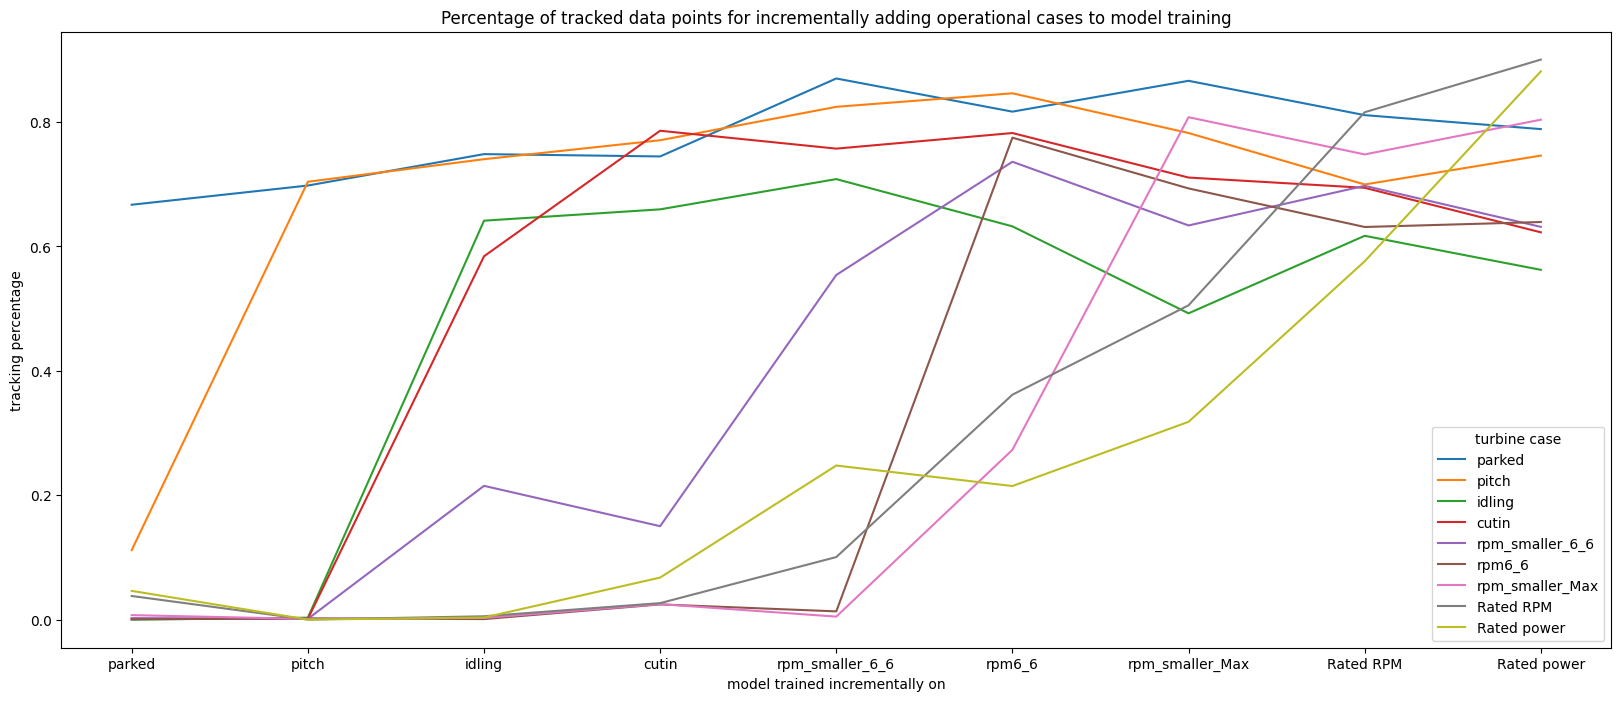

In [285]:
tracked_percentage_df = pd.DataFrame(index=predictions_insertion.keys())
for turbine_case in predictions_insertion.keys():
    try:
        
        tracked_percentages_ = []
        for turbine_case_model in models.keys():
        
            tracked_ = len(tracked_insertion[turbine_case_model][turbine_case])/len(predictions_insertion[turbine_case_model][turbine_case])
            tracked_percentages_.append(tracked_)
        tracked_df = pd.DataFrame(tracked_percentages_, index=predictions_insertion.keys(), columns=['mean_uncertainty'])
        tracked_percentage_df[turbine_case] = tracked_df 
    except Exception as e:
        print(e)
        
fig = plt.figure(figsize=(20,8))
plt.plot(tracked_percentage_df)
plt.legend()
plt.title('Percentage of tracked data points for incrementally adding operational cases to model training')
plt.legend(tracked_percentage_df.columns, title = 'turbine case')
plt.xlabel('model trained incrementally on')
plt.ylabel('tracking percentage')
plt.show()  

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


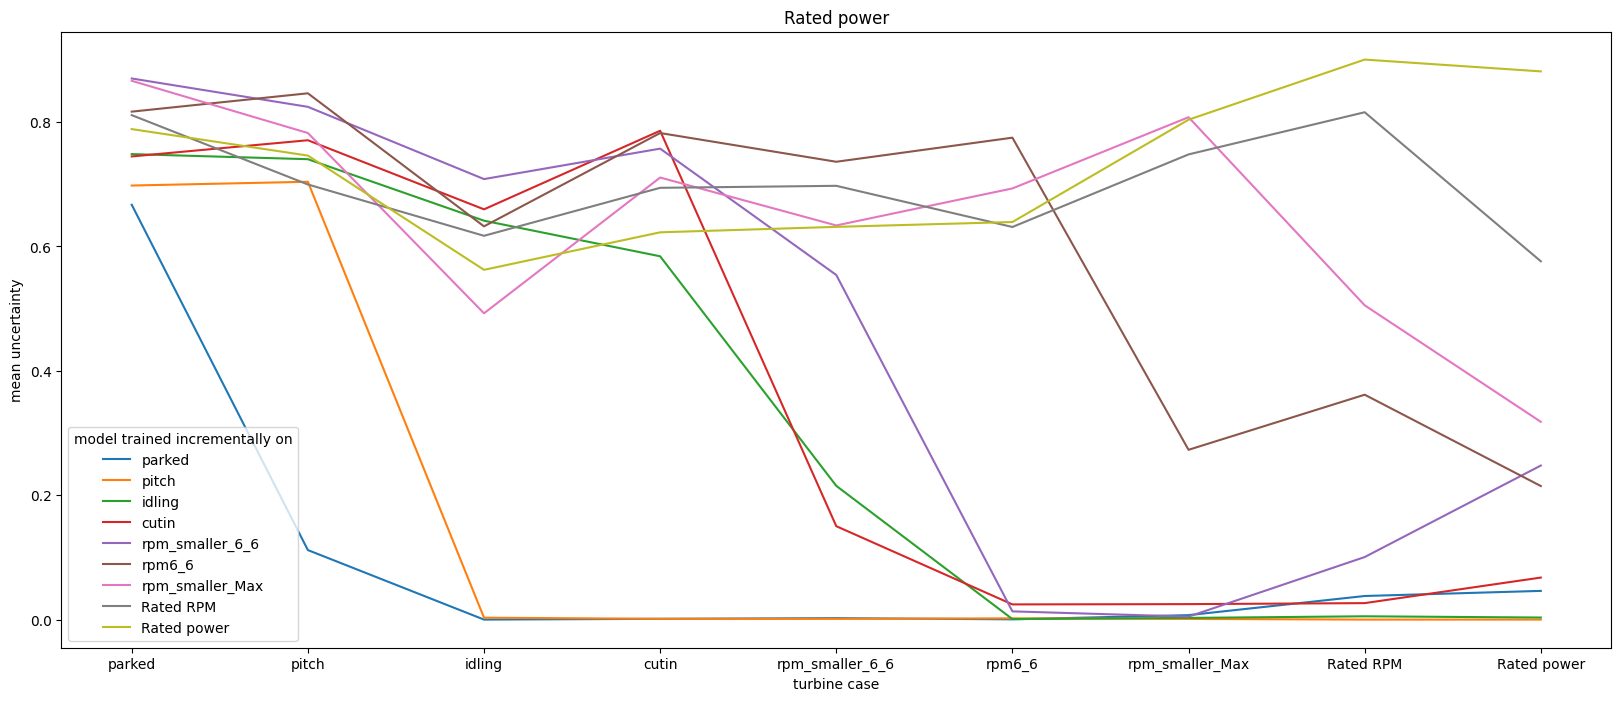

In [277]:
tracked_percentage_df = pd.DataFrame(index=predictions_insertion.keys())

for turbine_case_model in models.keys():
    try:
        
        tracked_percentages_ = []
        for turbine_case in predictions_insertion.keys():
        
            tracked_ = len(tracked_insertion[turbine_case_model][turbine_case])/len(predictions_insertion[turbine_case_model][turbine_case])
            tracked_percentages_.append(tracked_)
        tracked_df = pd.DataFrame(tracked_percentages_, index=predictions_insertion.keys(), columns=['mean_uncertainty'])
        tracked_percentage_df[turbine_case_model] = tracked_df 
    except Exception as e:
        print(e)
        
fig = plt.figure(figsize=(20,8))
plt.plot(tracked_percentage_df)
plt.legend()
plt.title(turbine_case_model)
plt.legend(tracked_percentage_df.columns, title = 'model trained incrementally on')
plt.xlabel('turbine case')
plt.ylabel('mean uncertainty')
plt.show()  

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


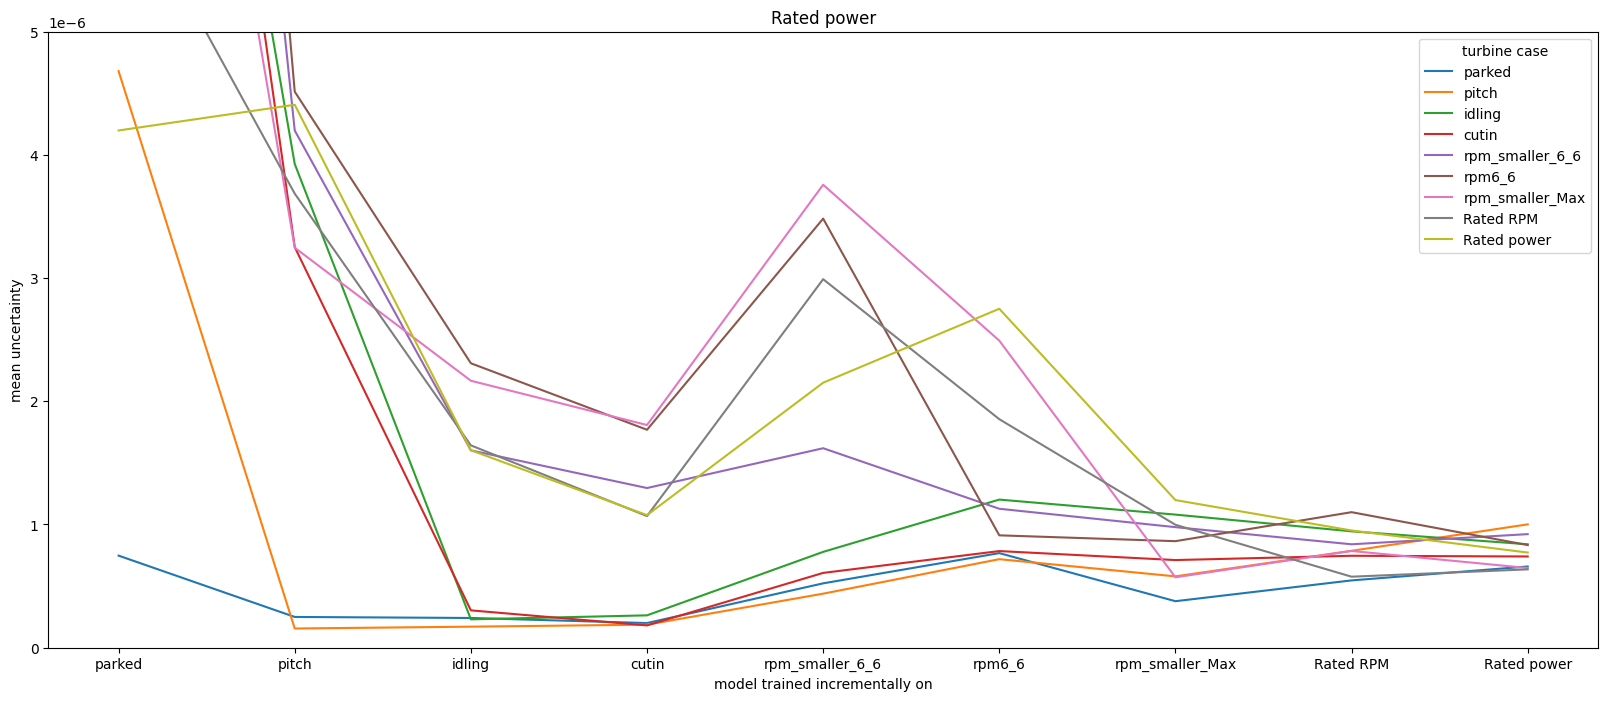

In [284]:
all_means = pd.DataFrame(index=predictions_insertion.keys())
for turbine_case in predictions_insertion.keys():
    try:
        
        means_ = []
        for turbine_case_model in models.keys():
        
            mean_uncertainty = predictions_insertion[turbine_case_model][turbine_case]['knowledge_uncertainty'].mean()
            means_.append(mean_uncertainty)
        means_df = pd.DataFrame(means_, index=predictions_insertion.keys(), columns=['mean_uncertainty'])
        all_means[turbine_case] = means_df 
    except Exception as e:
        print(e)
        
fig = plt.figure(figsize=(20,8))
plt.plot(all_means)
plt.legend()
plt.title(turbine_case_model)
plt.legend(all_means.columns, title = 'turbine case')
plt.xlabel('model trained incrementally on')
plt.ylabel('mean uncertainty')
plt.ylim([0, 5e-6])
plt.show()  

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


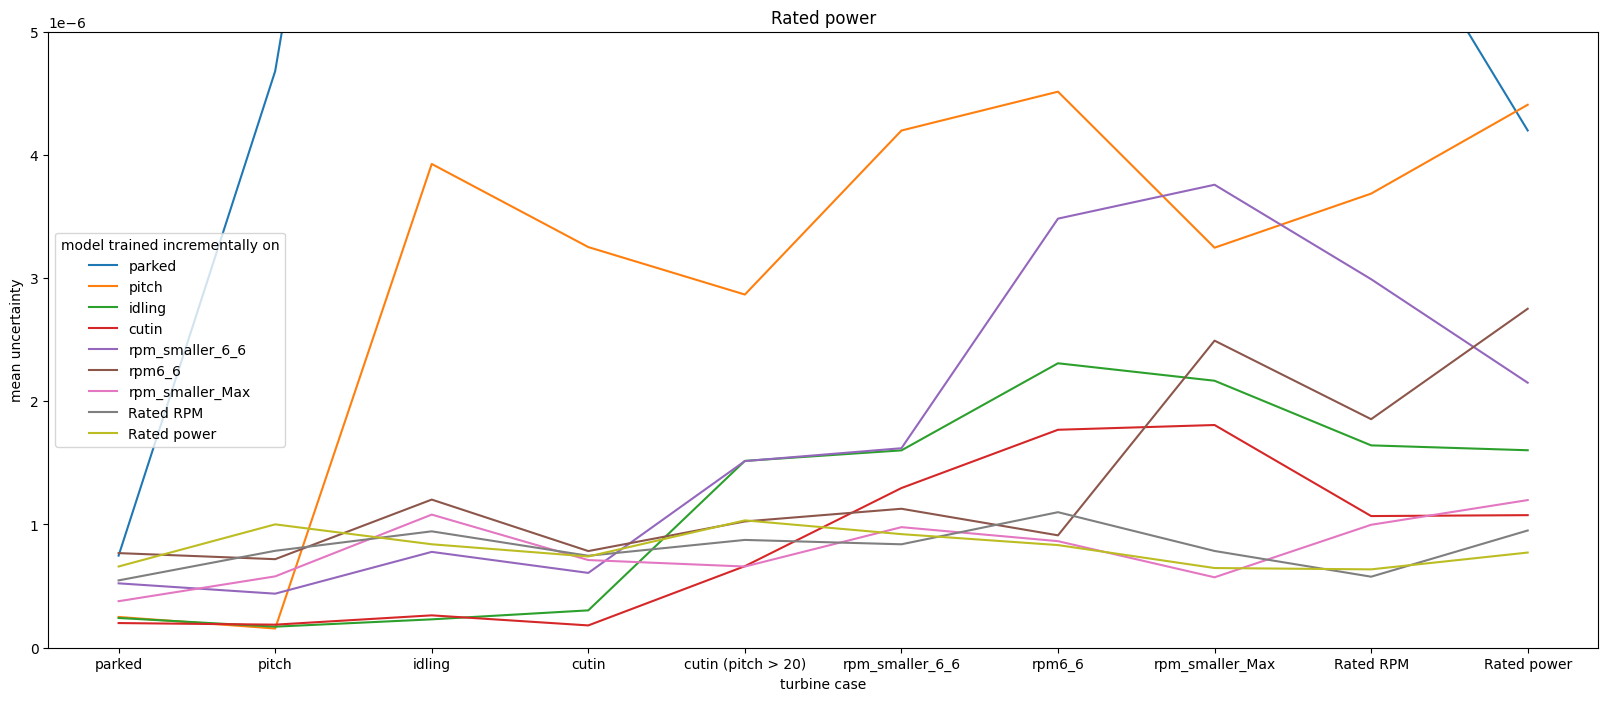

In [279]:
all_means = pd.DataFrame(index = turbine_case_inputs.keys())
for turbine_case_model in models.keys():
    try:
        
        means_ = []
        for turbine_case in turbine_case_inputs.keys():
            mean_uncertainty = predictions_insertion[turbine_case_model][turbine_case]['knowledge_uncertainty'].mean()
            means_.append(mean_uncertainty)
        means_df = pd.DataFrame(means_, index=turbine_case_inputs.keys(), columns=['mean_uncertainty'])
        all_means[turbine_case_model] = means_df
             
    except Exception as e:
        print(e)
fig = plt.figure(figsize=(20,8))
plt.plot(all_means)
plt.legend()
plt.title(turbine_case_model)
plt.legend(all_means.columns, title = 'model trained incrementally on')
plt.xlabel('turbine case')
plt.ylabel('mean uncertainty')
plt.ylim([0, 5e-6])
plt.show()  

parked parked 7.4627525733467e-07
parked pitch 4.678768167474449e-06
parked idling 1.2155050732560559e-05
parked cutin 1.3384649118517309e-05
parked cutin (pitch > 20) 1.2306866272417438e-05
parked rpm_smaller_6_6 1.7894133494706488e-05
parked rpm6_6 2.1028788429026177e-05
parked rpm_smaller_Max 1.1678544359541622e-05
parked Rated RPM 6.2879085576490364e-06
parked Rated power 4.197424014738071e-06
parked nan nan


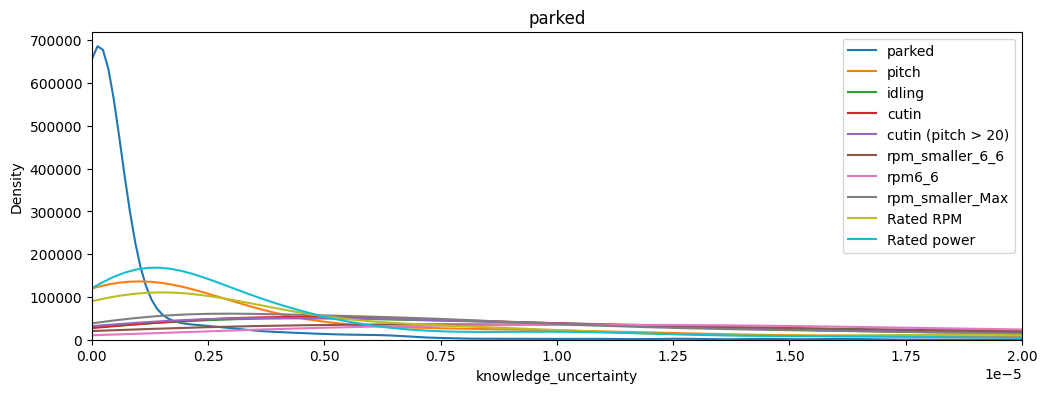

pitch parked 2.486278604270861e-07
pitch pitch 1.5475399887685282e-07
pitch idling 3.925475067251279e-06
pitch cutin 3.2508294165803216e-06
pitch cutin (pitch > 20) 2.865562595783005e-06
pitch rpm_smaller_6_6 4.196809763785263e-06
pitch rpm6_6 4.512300541614212e-06
pitch rpm_smaller_Max 3.245838590544916e-06
pitch Rated RPM 3.6846812690044463e-06
pitch Rated power 4.4059411674464545e-06
pitch nan nan


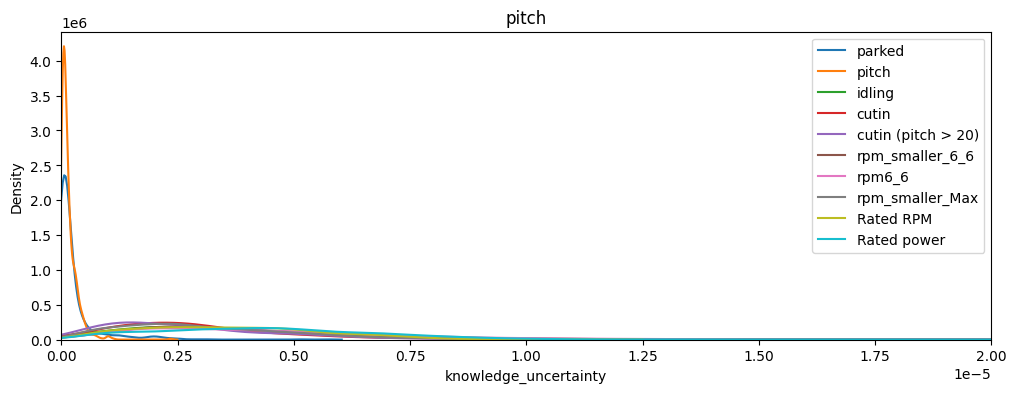

idling parked 2.4028488784560106e-07
idling pitch 1.6978671280354514e-07
idling idling 2.291555070372472e-07
idling cutin 3.0212359265041385e-07
idling cutin (pitch > 20) 1.5153730854104133e-06
idling rpm_smaller_6_6 1.6007614430867082e-06
idling rpm6_6 2.3077037160166818e-06
idling rpm_smaller_Max 2.1658578862364634e-06
idling Rated RPM 1.6413483213273601e-06
idling Rated power 1.6017229809674313e-06
idling nan nan


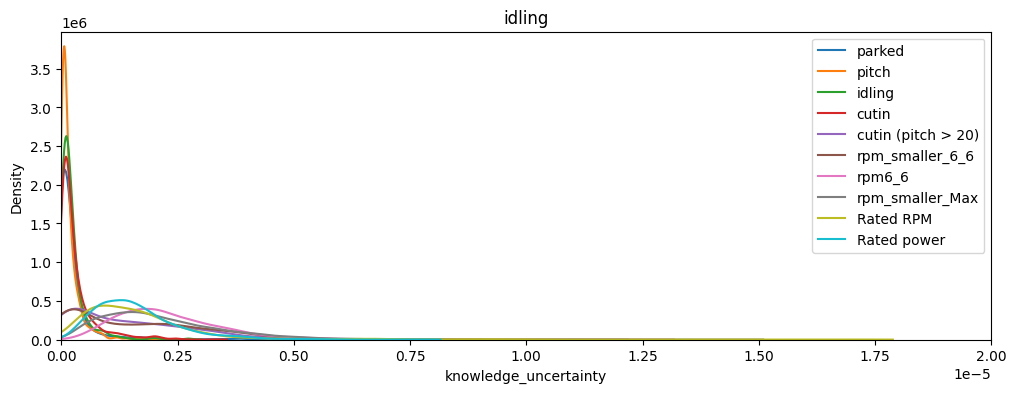

cutin parked 1.9908292178530454e-07
cutin pitch 1.8608120194247516e-07
cutin idling 2.6161391595613533e-07
cutin cutin 1.7993337420994723e-07
cutin cutin (pitch > 20) 6.607225913762498e-07
cutin rpm_smaller_6_6 1.2950071829682473e-06
cutin rpm6_6 1.7680167527370024e-06
cutin rpm_smaller_Max 1.8065308178346295e-06
cutin Rated RPM 1.0675132432840474e-06
cutin Rated power 1.074938093826067e-06
cutin nan nan


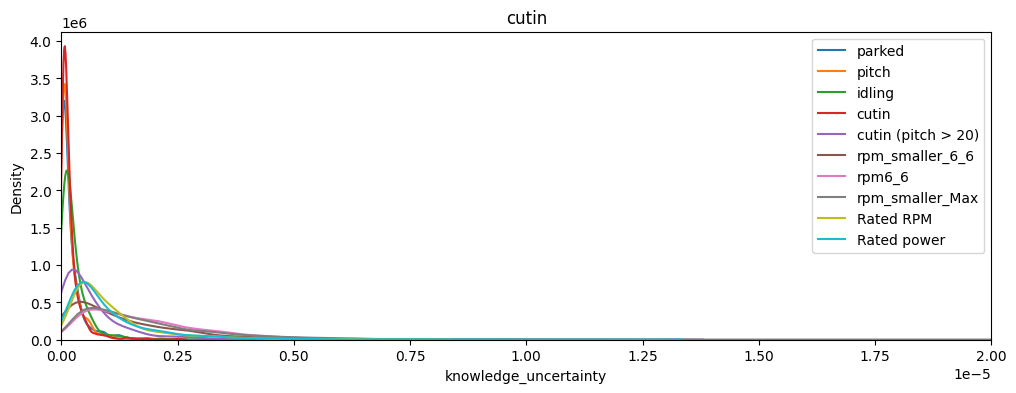

rpm_smaller_6_6 parked 5.213861688046556e-07
rpm_smaller_6_6 pitch 4.375581983809581e-07
rpm_smaller_6_6 idling 7.767943334528137e-07
rpm_smaller_6_6 cutin 6.061417348119146e-07
rpm_smaller_6_6 cutin (pitch > 20) 1.513865224651456e-06
rpm_smaller_6_6 rpm_smaller_6_6 1.6181193685199819e-06
rpm_smaller_6_6 rpm6_6 3.481787081144044e-06
rpm_smaller_6_6 rpm_smaller_Max 3.756807205501653e-06
rpm_smaller_6_6 Rated RPM 2.9901351568250618e-06
rpm_smaller_6_6 Rated power 2.149948241076837e-06
rpm_smaller_6_6 nan nan


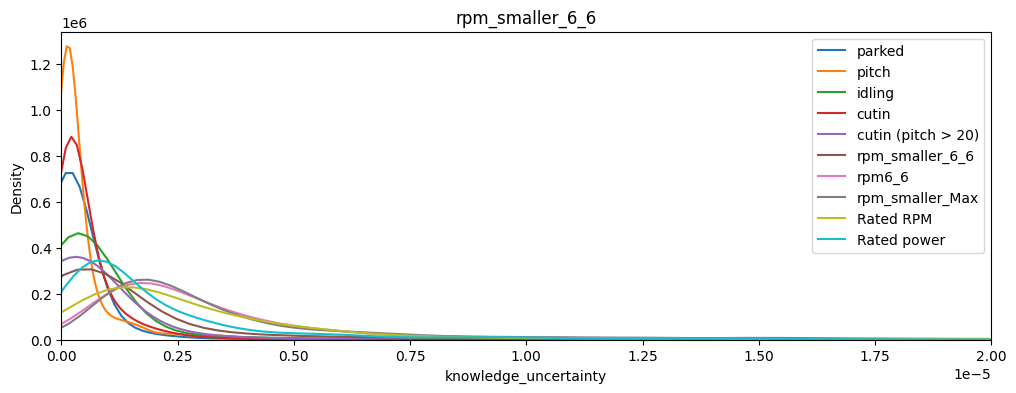

rpm6_6 parked 7.667927030904101e-07
rpm6_6 pitch 7.175608005707859e-07
rpm6_6 idling 1.2012368757927645e-06
rpm6_6 cutin 7.833627863313441e-07
rpm6_6 cutin (pitch > 20) 1.0239443598344377e-06
rpm6_6 rpm_smaller_6_6 1.1267777611107664e-06
rpm6_6 rpm6_6 9.111147294484731e-07
rpm6_6 rpm_smaller_Max 2.491391994444859e-06
rpm6_6 Rated RPM 1.853831764314009e-06
rpm6_6 Rated power 2.7502292837001676e-06
rpm6_6 nan nan


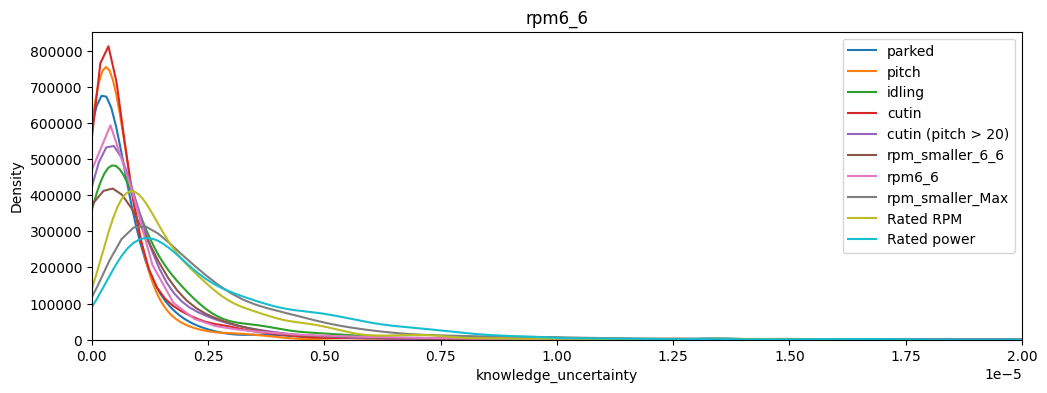

rpm_smaller_Max parked 3.7646317186461474e-07
rpm_smaller_Max pitch 5.779952998775165e-07
rpm_smaller_Max idling 1.0793678897512283e-06
rpm_smaller_Max cutin 7.103948058123768e-07
rpm_smaller_Max cutin (pitch > 20) 6.578316692388578e-07
rpm_smaller_Max rpm_smaller_6_6 9.774934155334723e-07
rpm_smaller_Max rpm6_6 8.637157452745561e-07
rpm_smaller_Max rpm_smaller_Max 5.704003512520405e-07
rpm_smaller_Max Rated RPM 9.967355399585721e-07
rpm_smaller_Max Rated power 1.1972358427877073e-06
rpm_smaller_Max nan nan


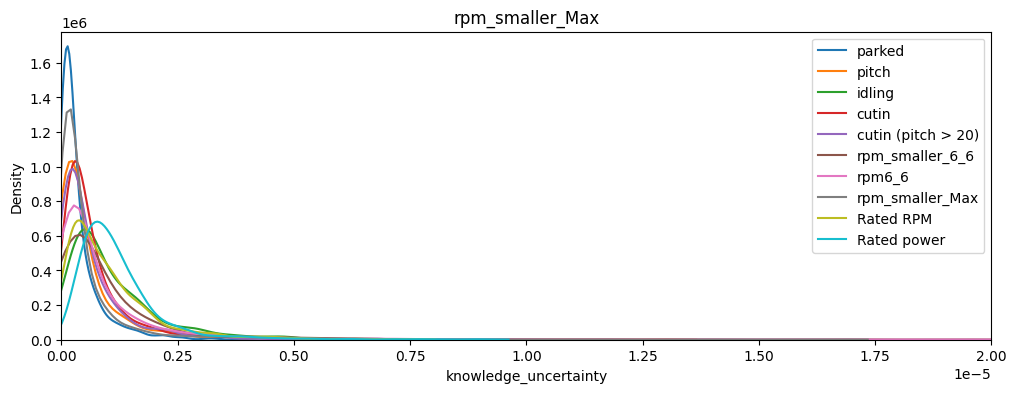

Rated RPM parked 5.452901313789224e-07
Rated RPM pitch 7.855329761524499e-07
Rated RPM idling 9.436035270156613e-07
Rated RPM cutin 7.452088866737424e-07
Rated RPM cutin (pitch > 20) 8.73851970800007e-07
Rated RPM rpm_smaller_6_6 8.383901570483254e-07
Rated RPM rpm6_6 1.0990304235488734e-06
Rated RPM rpm_smaller_Max 7.841582255230907e-07
Rated RPM Rated RPM 5.753795871019977e-07
Rated RPM Rated power 9.503677320585275e-07
Rated RPM nan nan


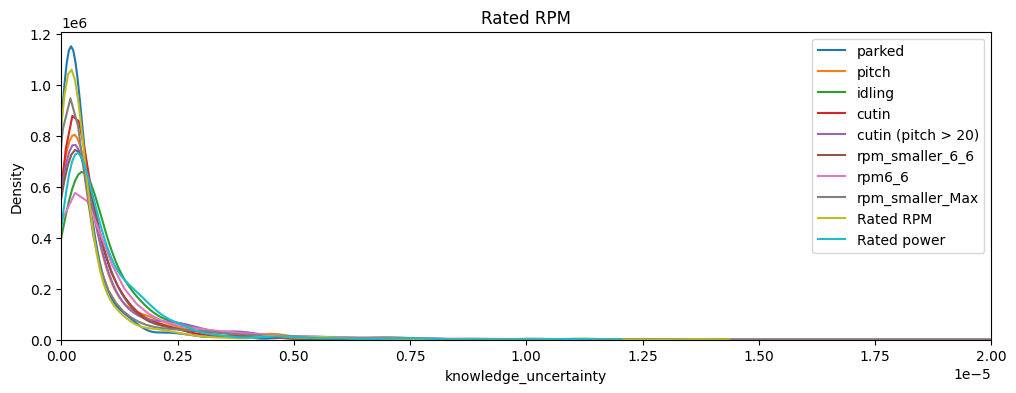

Rated power parked 6.582201361741074e-07
Rated power pitch 1.0001882207404387e-06
Rated power idling 8.385098721574085e-07
Rated power cutin 7.394314986733395e-07
Rated power cutin (pitch > 20) 1.0325071671094059e-06
Rated power rpm_smaller_6_6 9.208538318804462e-07
Rated power rpm6_6 8.319958648851069e-07
Rated power rpm_smaller_Max 6.457103722405754e-07
Rated power Rated RPM 6.349255577493835e-07
Rated power Rated power 7.713259200609384e-07
Rated power nan nan


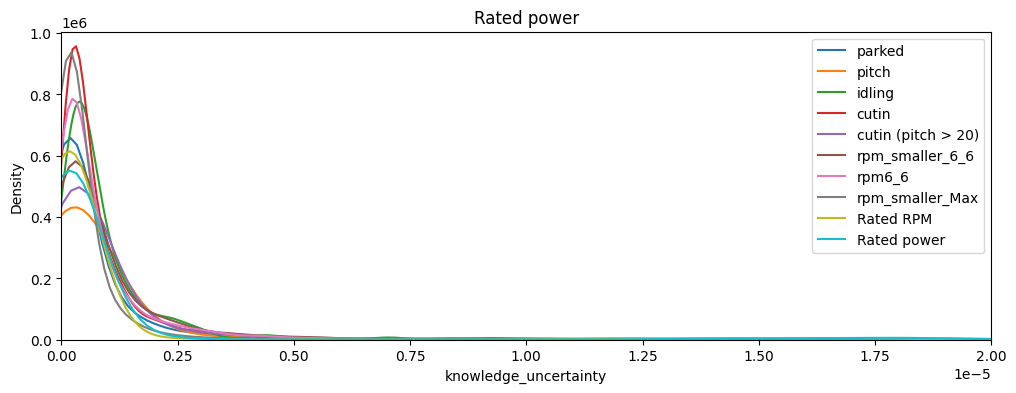

In [280]:
import seaborn as sns

for turbine_case_model in models.keys():
    try:
        fig = plt.figure(figsize=(12,4))
        for turbine_case in turbine_case_inputs.keys():
            sns.kdeplot(predictions_insertion[turbine_case_model][turbine_case]['knowledge_uncertainty'], label=turbine_case)
            print(turbine_case_model, turbine_case, predictions_insertion[turbine_case_model][turbine_case]['knowledge_uncertainty'].mean())
        plt.legend()
        plt.title(turbine_case_model)
        plt.xlim(0,2e-5)
        plt.show()       
    except Exception as e:
        print(e)

parked parked 7.4627525733467e-07
parked pitch 4.678768167474449e-06
parked idling 1.2155050732560559e-05
parked cutin 1.3384649118517309e-05
parked cutin (pitch > 20) 1.2306866272417438e-05
parked rpm_smaller_6_6 1.7894133494706488e-05
parked rpm6_6 2.1028788429026177e-05
parked rpm_smaller_Max 1.1678544359541622e-05
parked Rated RPM 6.2879085576490364e-06
parked Rated power 4.197424014738071e-06
parked nan nan


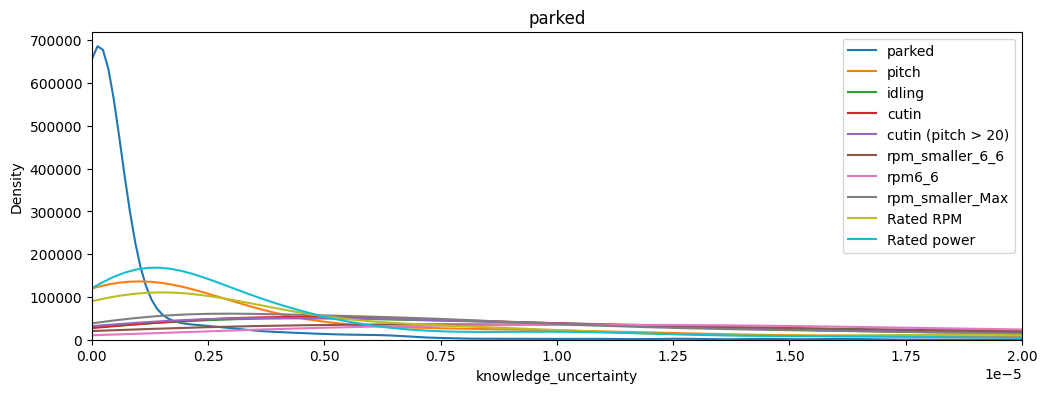

pitch parked 3.753987931920086e-06
pitch pitch 2.419523661912919e-07
pitch idling 5.00030093007665e-06
pitch cutin 3.3228784421359944e-06
pitch cutin (pitch > 20) 3.295935519526994e-06
pitch rpm_smaller_6_6 3.749869847769441e-06
pitch rpm6_6 4.678895319649435e-06
pitch rpm_smaller_Max 3.854967323000892e-06
pitch Rated RPM 2.776455423744569e-06
pitch Rated power 2.5462219111847254e-06
pitch nan nan


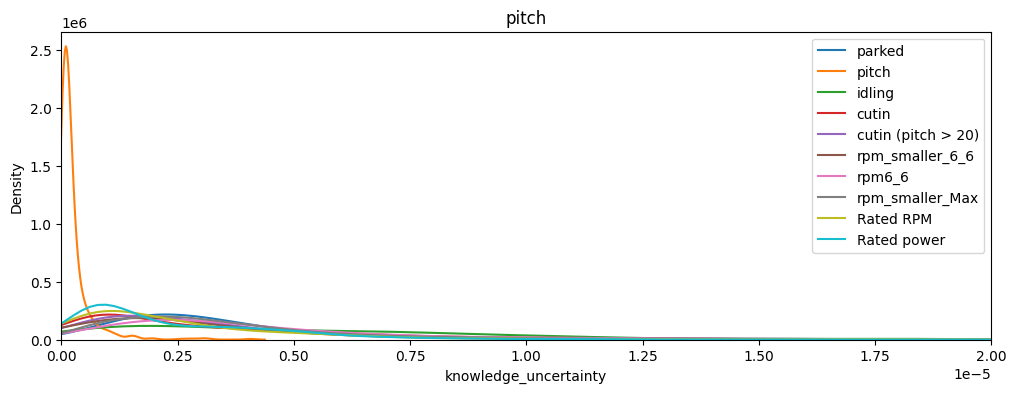

idling parked 2.0019480821112474e-05
idling pitch 8.626920069740583e-06
idling idling 7.581807399608793e-07
idling cutin 1.578694447308408e-06
idling cutin (pitch > 20) 6.16385375808691e-06
idling rpm_smaller_6_6 4.275342027912062e-06
idling rpm6_6 4.180636504922952e-06
idling rpm_smaller_Max 1.3892655747055316e-05
idling Rated RPM 2.6589443133718287e-05
idling Rated power 2.649076163148967e-05
idling nan nan


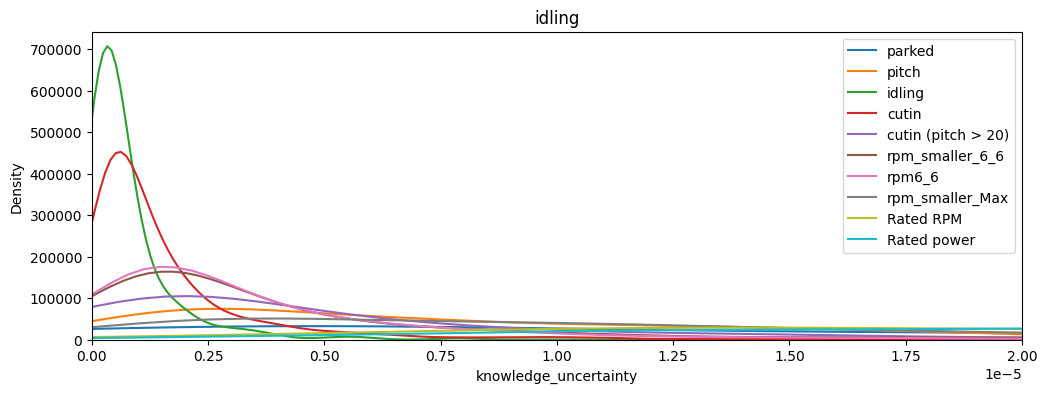

cutin parked 9.250250215544901e-07
cutin pitch 9.169754992580124e-07
cutin idling 2.5288766994908035e-07
cutin cutin 1.539676351158053e-07
cutin cutin (pitch > 20) 5.326149880613549e-07
cutin rpm_smaller_6_6 1.3521372278541103e-06
cutin rpm6_6 1.6108239911098062e-06
cutin rpm_smaller_Max 3.2747869751306216e-06
cutin Rated RPM 5.169678857229225e-06
cutin Rated power 5.6053969485157525e-06
cutin nan nan


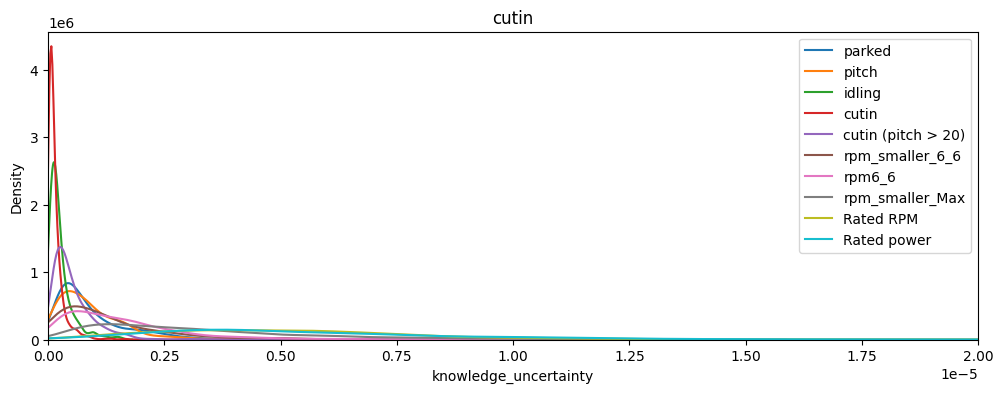

rpm_smaller_6_6 parked 2.3719430137515193e-05
rpm_smaller_6_6 pitch 2.4508646327439522e-05
rpm_smaller_6_6 idling 2.4792462934311323e-05
rpm_smaller_6_6 cutin 1.1587308808698835e-05
rpm_smaller_6_6 cutin (pitch > 20) 1.183520841764454e-05
rpm_smaller_6_6 rpm_smaller_6_6 2.89993108043725e-06
rpm_smaller_6_6 rpm6_6 6.184917768772629e-06
rpm_smaller_6_6 rpm_smaller_Max 6.855289054126657e-06
rpm_smaller_6_6 Rated RPM 1.0270361811197844e-05
rpm_smaller_6_6 Rated power 9.07154812592296e-06
rpm_smaller_6_6 nan nan


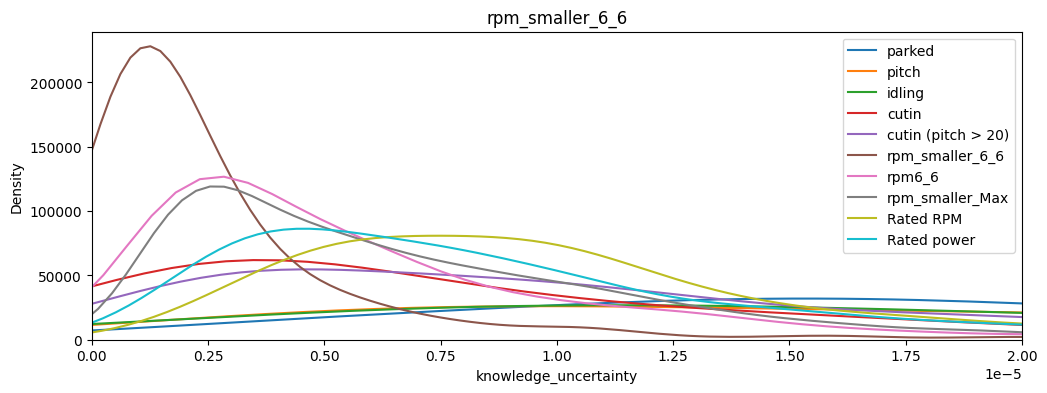

rpm6_6 parked 8.046684818248125e-06
rpm6_6 pitch 9.84470667933452e-06
rpm6_6 idling 1.7717591932223164e-05
rpm6_6 cutin 1.5110830993982442e-05
rpm6_6 cutin (pitch > 20) 1.2022760776829598e-05
rpm6_6 rpm_smaller_6_6 9.949218891444696e-06
rpm6_6 rpm6_6 2.027371124693461e-06
rpm6_6 rpm_smaller_Max 4.1038881614276385e-06
rpm6_6 Rated RPM 4.489561662302958e-06
rpm6_6 Rated power 5.736278253040232e-06
rpm6_6 nan nan


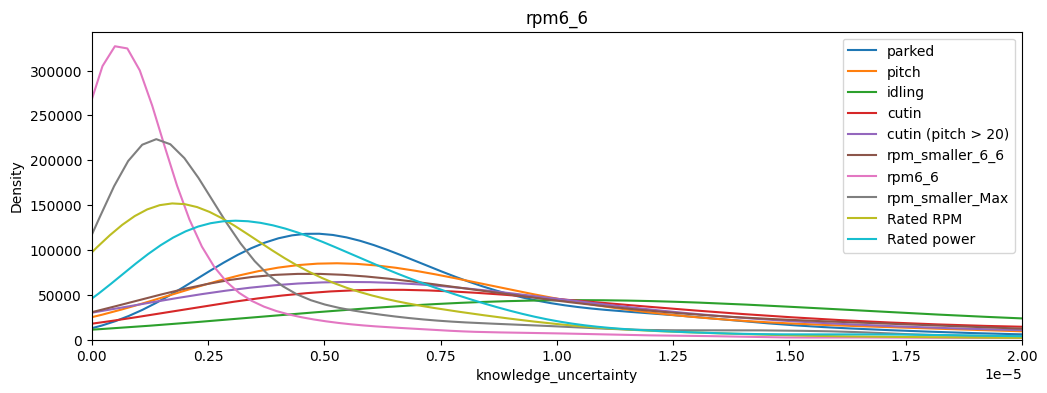

rpm_smaller_Max parked 3.306866213287912e-06
rpm_smaller_Max pitch 3.731822678530664e-06
rpm_smaller_Max idling 2.4907168559288004e-06
rpm_smaller_Max cutin 2.072649785581883e-06
rpm_smaller_Max cutin (pitch > 20) 3.3895394160672728e-06
rpm_smaller_Max rpm_smaller_6_6 2.153402621736555e-06
rpm_smaller_Max rpm6_6 1.7225327091807653e-06
rpm_smaller_Max rpm_smaller_Max 2.921863333824527e-07
rpm_smaller_Max Rated RPM 1.8691989431907433e-06
rpm_smaller_Max Rated power 2.7407637151866215e-06
rpm_smaller_Max nan nan


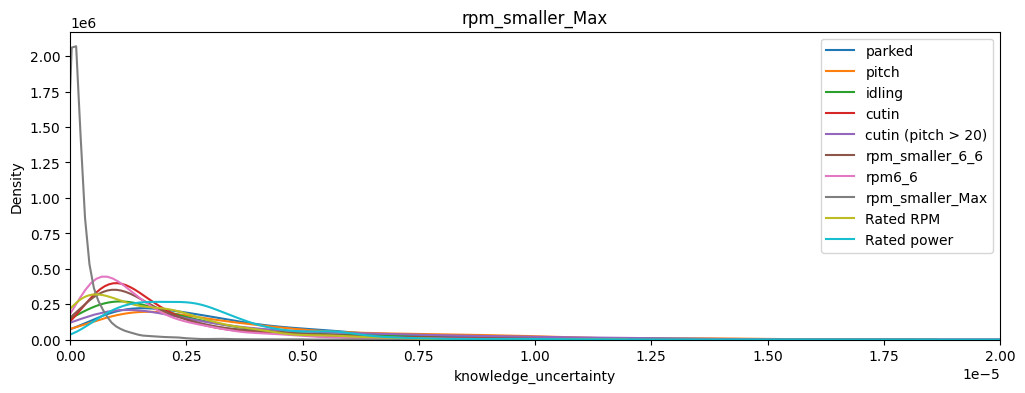

Rated RPM parked 1.3397919050385729e-06
Rated RPM pitch 1.6617561565636575e-06
Rated RPM idling 2.790071500148144e-06
Rated RPM cutin 2.462911280793893e-06
Rated RPM cutin (pitch > 20) 2.0791596154121286e-06
Rated RPM rpm_smaller_6_6 1.6333481969636006e-06
Rated RPM rpm6_6 1.2583984276414917e-06
Rated RPM rpm_smaller_Max 1.317414154547511e-06
Rated RPM Rated RPM 2.2224048801160576e-07
Rated RPM Rated power 8.558007557605598e-07
Rated RPM nan nan


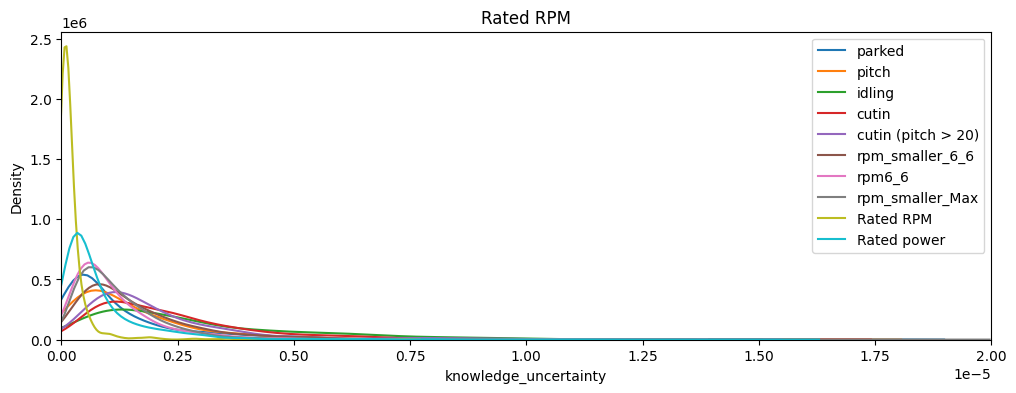

Rated power parked 5.256963717415481e-06
Rated power pitch 8.981758521828797e-06
Rated power idling 1.310110712129297e-05
Rated power cutin 1.2737204604809376e-05
Rated power cutin (pitch > 20) 1.1332123899827107e-05
Rated power rpm_smaller_6_6 4.353645090889883e-06
Rated power rpm6_6 1.7833302333187146e-06
Rated power rpm_smaller_Max 2.0521875050879783e-06
Rated power Rated RPM 8.976912509906694e-07
Rated power Rated power 2.915360608779743e-07
Rated power nan nan


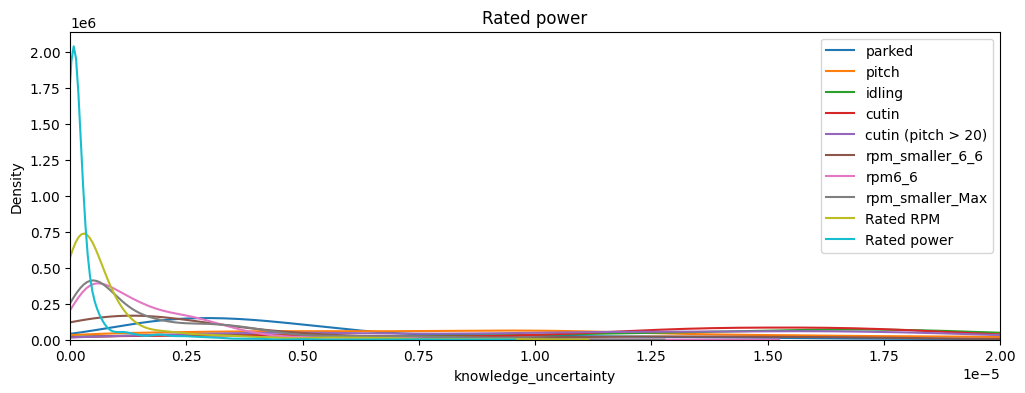

In [281]:
import seaborn as sns

for turbine_case_model in models.keys():
    try:
        fig = plt.figure(figsize=(12,4))
        for turbine_case in turbine_case_inputs.keys():
            sns.kdeplot(predictions[turbine_case_model][turbine_case]['knowledge_uncertainty'], label=turbine_case)
            print(turbine_case_model, turbine_case, predictions[turbine_case_model][turbine_case]['knowledge_uncertainty'].mean())
        plt.legend()
        plt.title(turbine_case_model)
        plt.xlim(0,2e-5)
        plt.show()       
    except Exception as e:
        print(e)

parked parked 7.4627525733467e-07
pitch parked 3.753987931920086e-06
idling parked 2.0019480821112474e-05
cutin parked 9.250250215544901e-07
rpm_smaller_6_6 parked 2.3719430137515193e-05
rpm6_6 parked 8.046684818248125e-06
rpm_smaller_Max parked 3.306866213287912e-06
Rated RPM parked 1.3397919050385729e-06
Rated power parked 5.256963717415481e-06


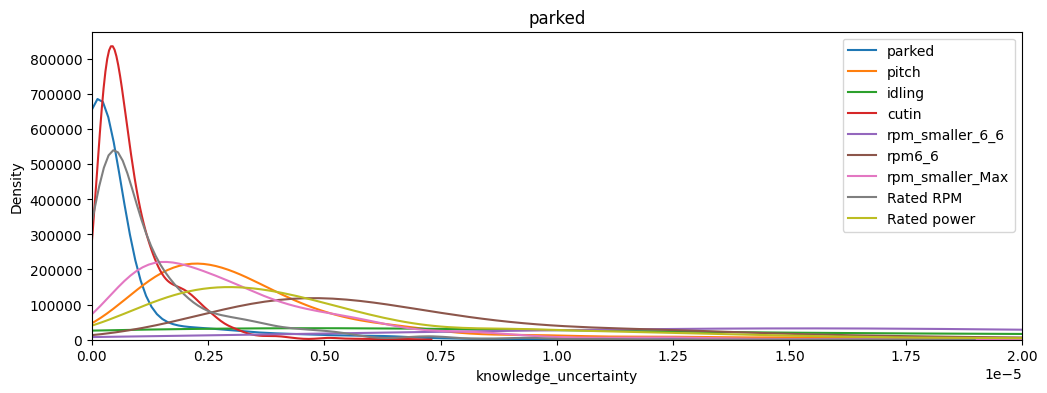

parked pitch 4.678768167474449e-06
pitch pitch 2.419523661912919e-07
idling pitch 8.626920069740583e-06
cutin pitch 9.169754992580124e-07
rpm_smaller_6_6 pitch 2.4508646327439522e-05
rpm6_6 pitch 9.84470667933452e-06
rpm_smaller_Max pitch 3.731822678530664e-06
Rated RPM pitch 1.6617561565636575e-06
Rated power pitch 8.981758521828797e-06


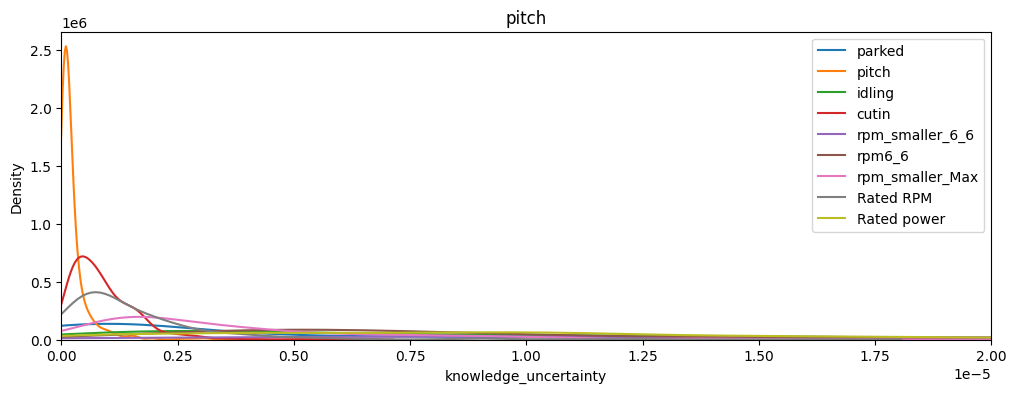

parked idling 1.2155050732560559e-05
pitch idling 5.00030093007665e-06
idling idling 7.581807399608793e-07
cutin idling 2.5288766994908035e-07
rpm_smaller_6_6 idling 2.4792462934311323e-05
rpm6_6 idling 1.7717591932223164e-05
rpm_smaller_Max idling 2.4907168559288004e-06
Rated RPM idling 2.790071500148144e-06
Rated power idling 1.310110712129297e-05


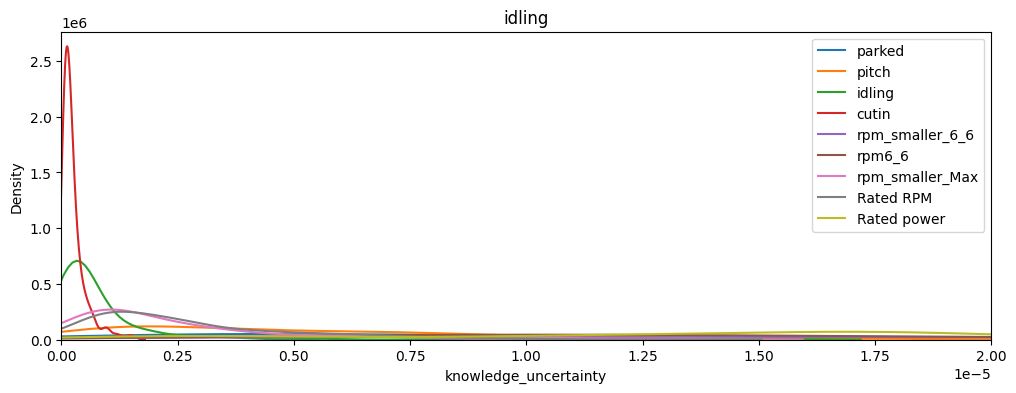

parked cutin 1.3384649118517309e-05
pitch cutin 3.3228784421359944e-06
idling cutin 1.578694447308408e-06
cutin cutin 1.539676351158053e-07
rpm_smaller_6_6 cutin 1.1587308808698835e-05
rpm6_6 cutin 1.5110830993982442e-05
rpm_smaller_Max cutin 2.072649785581883e-06
Rated RPM cutin 2.462911280793893e-06
Rated power cutin 1.2737204604809376e-05


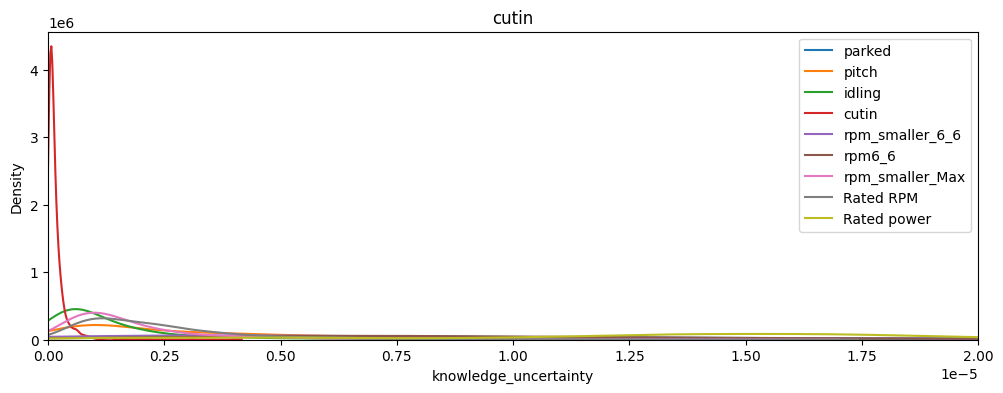

parked cutin (pitch > 20) 1.2306866272417438e-05
pitch cutin (pitch > 20) 3.295935519526994e-06
idling cutin (pitch > 20) 6.16385375808691e-06
cutin cutin (pitch > 20) 5.326149880613549e-07
rpm_smaller_6_6 cutin (pitch > 20) 1.183520841764454e-05
rpm6_6 cutin (pitch > 20) 1.2022760776829598e-05
rpm_smaller_Max cutin (pitch > 20) 3.3895394160672728e-06
Rated RPM cutin (pitch > 20) 2.0791596154121286e-06
Rated power cutin (pitch > 20) 1.1332123899827107e-05


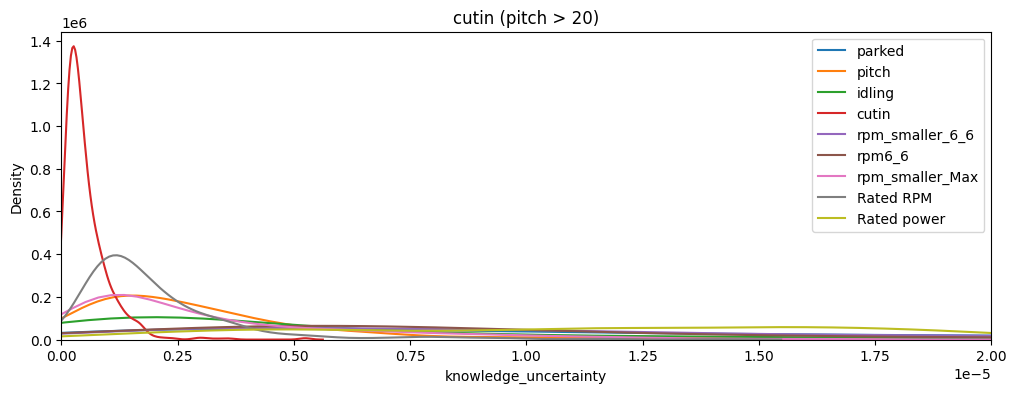

parked rpm_smaller_6_6 1.7894133494706488e-05
pitch rpm_smaller_6_6 3.749869847769441e-06
idling rpm_smaller_6_6 4.275342027912062e-06
cutin rpm_smaller_6_6 1.3521372278541103e-06
rpm_smaller_6_6 rpm_smaller_6_6 2.89993108043725e-06
rpm6_6 rpm_smaller_6_6 9.949218891444696e-06
rpm_smaller_Max rpm_smaller_6_6 2.153402621736555e-06
Rated RPM rpm_smaller_6_6 1.6333481969636006e-06
Rated power rpm_smaller_6_6 4.353645090889883e-06


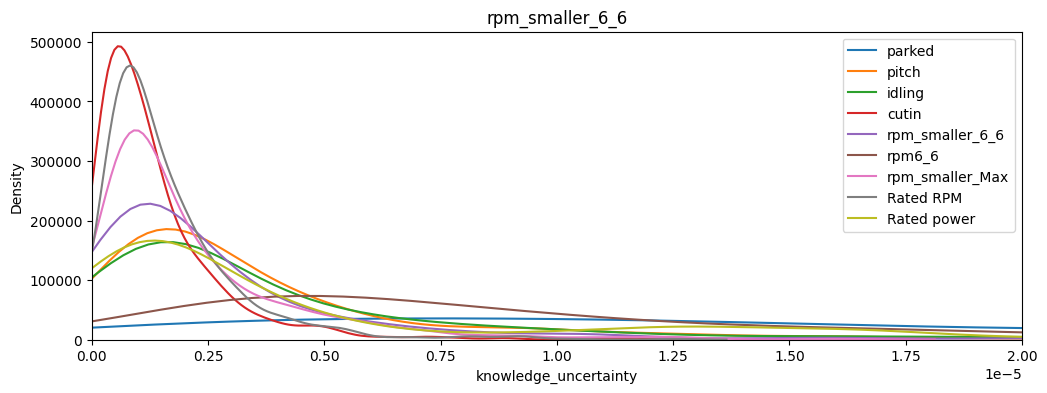

parked rpm6_6 2.1028788429026177e-05
pitch rpm6_6 4.678895319649435e-06
idling rpm6_6 4.180636504922952e-06
cutin rpm6_6 1.6108239911098062e-06
rpm_smaller_6_6 rpm6_6 6.184917768772629e-06
rpm6_6 rpm6_6 2.027371124693461e-06
rpm_smaller_Max rpm6_6 1.7225327091807653e-06
Rated RPM rpm6_6 1.2583984276414917e-06
Rated power rpm6_6 1.7833302333187146e-06


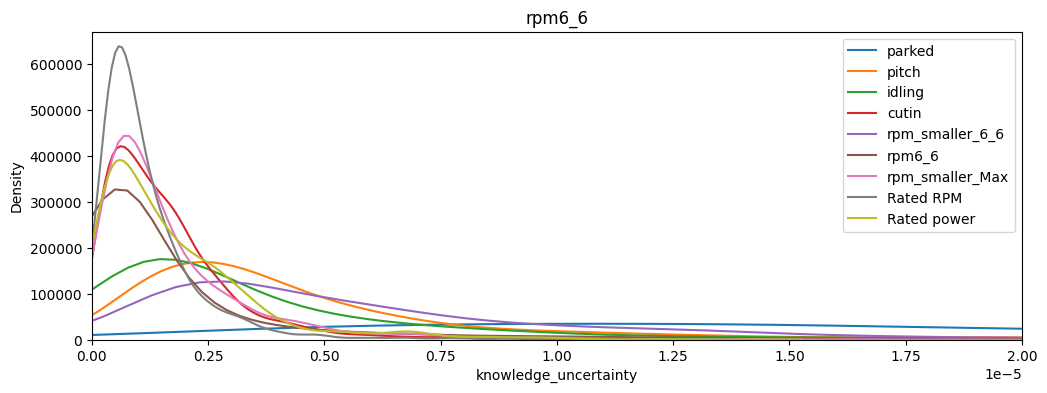

parked rpm_smaller_Max 1.1678544359541622e-05
pitch rpm_smaller_Max 3.854967323000892e-06
idling rpm_smaller_Max 1.3892655747055316e-05
cutin rpm_smaller_Max 3.2747869751306216e-06
rpm_smaller_6_6 rpm_smaller_Max 6.855289054126657e-06
rpm6_6 rpm_smaller_Max 4.1038881614276385e-06
rpm_smaller_Max rpm_smaller_Max 2.921863333824527e-07
Rated RPM rpm_smaller_Max 1.317414154547511e-06
Rated power rpm_smaller_Max 2.0521875050879783e-06


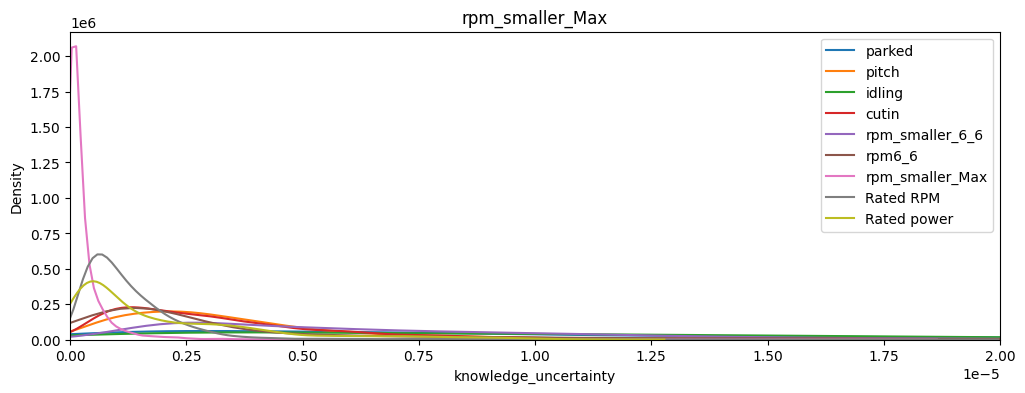

parked Rated RPM 6.2879085576490364e-06
pitch Rated RPM 2.776455423744569e-06
idling Rated RPM 2.6589443133718287e-05
cutin Rated RPM 5.169678857229225e-06
rpm_smaller_6_6 Rated RPM 1.0270361811197844e-05
rpm6_6 Rated RPM 4.489561662302958e-06
rpm_smaller_Max Rated RPM 1.8691989431907433e-06
Rated RPM Rated RPM 2.2224048801160576e-07
Rated power Rated RPM 8.976912509906694e-07


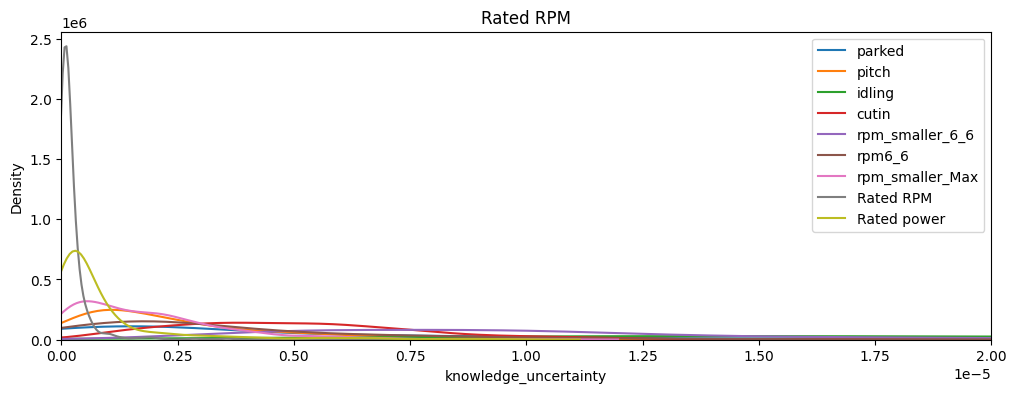

parked Rated power 4.197424014738071e-06
pitch Rated power 2.5462219111847254e-06
idling Rated power 2.649076163148967e-05
cutin Rated power 5.6053969485157525e-06
rpm_smaller_6_6 Rated power 9.07154812592296e-06
rpm6_6 Rated power 5.736278253040232e-06
rpm_smaller_Max Rated power 2.7407637151866215e-06
Rated RPM Rated power 8.558007557605598e-07
Rated power Rated power 2.915360608779743e-07


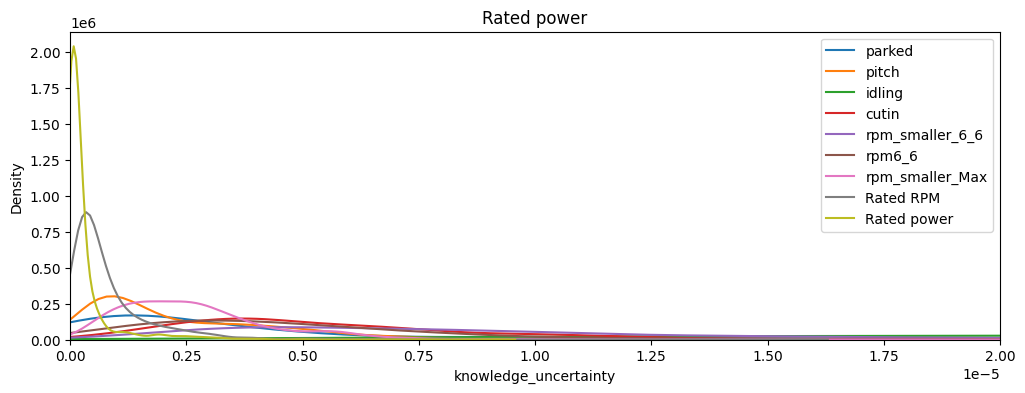

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


parked nan nan
pitch nan nan
idling nan nan
cutin nan nan
rpm_smaller_6_6 nan nan
rpm6_6 nan nan
rpm_smaller_Max nan nan
Rated RPM nan nan
Rated power nan nan


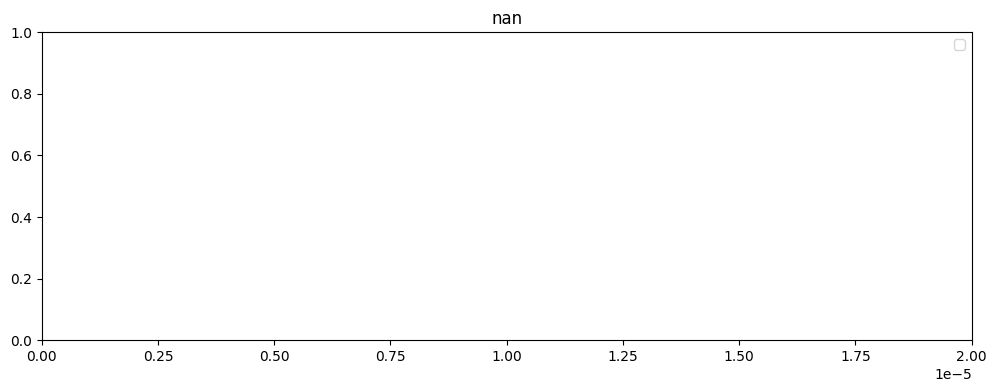

In [282]:
import seaborn as sns
for turbine_case in turbine_case_inputs.keys():

    try:
        fig = plt.figure(figsize=(12,4))
        for turbine_case_model in models.keys():
            sns.kdeplot(predictions[turbine_case_model][turbine_case]['knowledge_uncertainty'], label=turbine_case_model)
            print(turbine_case_model, turbine_case, predictions[turbine_case_model][turbine_case]['knowledge_uncertainty'].mean())
        plt.legend()
        plt.title(turbine_case)
        plt.xlim(0,2e-5)
        plt.show()       
    except Exception as e:
        print(e)